# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.9/500.9 KB 13.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 6.0 MB/s eta 0:00:0000:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 13.4 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 29.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 10.8 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [10]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [11]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [12]:
client = MongoClient(mongod_connect)
db = client.lab9 # use or create a database named demo
tweet_collection = db.tweet_collection #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [13]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [14]:
count = 100 #number of returned tweets, default and max is 100
geocode = "38.4392897,-78.9412224,50mi"  # defin the location, in Harrisonburg, VA
q = "election"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [15]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 07 21:09:04 +0000 2022'
'Mon Nov 07 21:06:52 +0000 2022'
'Mon Nov 07 21:06:50 +0000 2022'
'Mon Nov 07 21:01:03 +0000 2022'
'Mon Nov 07 21:00:36 +0000 2022'
'Mon Nov 07 20:59:29 +0000 2022'
'Mon Nov 07 20:56:45 +0000 2022'
'Mon Nov 07 20:53:07 +0000 2022'
'Mon Nov 07 20:48:19 +0000 2022'
'Mon Nov 07 20:45:55 +0000 2022'
'Mon Nov 07 20:40:35 +0000 2022'
'Mon Nov 07 20:37:27 +0000 2022'
'Mon Nov 07 20:37:24 +0000 2022'
'Mon Nov 07 20:37:10 +0000 2022'
'Mon Nov 07 20:35:28 +0000 2022'
'Mon Nov 07 20:34:32 +0000 2022'
'Mon Nov 07 20:33:59 +0000 2022'
'Mon Nov 07 20:30:27 +0000 2022'
'Mon Nov 07 20:27:28 +0000 2022'
'Mon Nov 07 20:25:07 +0000 2022'
'Mon Nov 07 20:21:18 +0000 2022'
'Mon Nov 07 20:21:16 +0000 2022'
'Mon Nov 07 20:19:50 +0000 2022'
'Mon Nov 07 20:19:02 +0000 2022'
'Mon Nov 07 20:18:03 +0000 2022'
'Mon Nov 07 20:12:00 +0000 2022'
'Mon Nov 07 20:02:44 +0000 2022'
'Mon Nov 07 20:01:18 +0000 2022'
'Mon Nov 07 19:58:39 +0000 2022'
'Mon Nov 07 19:39:24 +0000 2022'
'Mon Nov 0

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [16]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Mon Nov 07 15:33:03 +0000 2022'
'Mon Nov 07 15:30:12 +0000 2022'
'Mon Nov 07 15:30:10 +0000 2022'
'Mon Nov 07 15:28:42 +0000 2022'
'Mon Nov 07 15:27:28 +0000 2022'
'Mon Nov 07 15:26:38 +0000 2022'
'Mon Nov 07 15:20:17 +0000 2022'
'Mon Nov 07 15:14:29 +0000 2022'
'Mon Nov 07 15:14:17 +0000 2022'
'Mon Nov 07 15:08:30 +0000 2022'
'Mon Nov 07 15:06:13 +0000 2022'
'Mon Nov 07 15:06:00 +0000 2022'
'Mon Nov 07 15:05:20 +0000 2022'
'Mon Nov 07 15:04:30 +0000 2022'
'Mon Nov 07 15:02:27 +0000 2022'
'Mon Nov 07 14:55:44 +0000 2022'
'Mon Nov 07 14:46:45 +0000 2022'
'Mon Nov 07 14:44:00 +0000 2022'
'Mon Nov 07 14:42:47 +0000 2022'
'Mon Nov 07 14:40:23 +0000 2022'
'Mon Nov 07 14:39:15 +0000 2022'
'Mon Nov 07 14:34:00 +0000 2022'
'Mon Nov 07 14:33:29 +0000 2022'
'Mon Nov 07 14:31:39 +0000 2022'
'Mon Nov 07 14:27:52 +0000 2022'
'Mon Nov 07 14:22:25 +0000 2022'
'Mon Nov 07 14:19:00 +0000 2022'
'Mon Nov 07 14:15:28 +0000 2022'
'Mon Nov 07 14:11:41 +0000 2022'
'Mon Nov 07 14:05:48 +0000 2022'
'Mon Nov 0

'Sat Nov 05 19:59:49 +0000 2022'
'Sat Nov 05 19:43:45 +0000 2022'
'Sat Nov 05 19:33:47 +0000 2022'
'Sat Nov 05 19:15:51 +0000 2022'
'Sat Nov 05 19:04:20 +0000 2022'
'Sat Nov 05 18:38:53 +0000 2022'
'Sat Nov 05 18:33:00 +0000 2022'
'Sat Nov 05 18:31:12 +0000 2022'
'Sat Nov 05 18:10:59 +0000 2022'
'Sat Nov 05 17:57:55 +0000 2022'
'Sat Nov 05 17:30:40 +0000 2022'
'Sat Nov 05 17:21:54 +0000 2022'
'Sat Nov 05 17:07:57 +0000 2022'
'Sat Nov 05 16:59:05 +0000 2022'
'Sat Nov 05 16:36:37 +0000 2022'
'Sat Nov 05 16:24:02 +0000 2022'
'Sat Nov 05 16:19:59 +0000 2022'
'Sat Nov 05 16:10:33 +0000 2022'
'Sat Nov 05 16:09:31 +0000 2022'
'Sat Nov 05 16:08:49 +0000 2022'
'Sat Nov 05 15:48:43 +0000 2022'
'Sat Nov 05 15:46:20 +0000 2022'
'Sat Nov 05 15:42:00 +0000 2022'
'Sat Nov 05 15:32:22 +0000 2022'
'Sat Nov 05 15:16:04 +0000 2022'
'Sat Nov 05 14:55:36 +0000 2022'
'Sat Nov 05 14:42:44 +0000 2022'
'Sat Nov 05 14:41:43 +0000 2022'
'Sat Nov 05 14:33:11 +0000 2022'
'Sat Nov 05 14:15:53 +0000 2022'
'Sat Nov 0

'Fri Nov 04 02:13:08 +0000 2022'
'Fri Nov 04 02:05:53 +0000 2022'
'Fri Nov 04 02:04:06 +0000 2022'
'Fri Nov 04 02:03:54 +0000 2022'
'Fri Nov 04 01:54:47 +0000 2022'
'Fri Nov 04 01:51:11 +0000 2022'
'Fri Nov 04 01:50:48 +0000 2022'
'Fri Nov 04 01:48:23 +0000 2022'
'Fri Nov 04 01:45:39 +0000 2022'
'Fri Nov 04 01:41:36 +0000 2022'
'Fri Nov 04 01:41:12 +0000 2022'
'Fri Nov 04 01:38:53 +0000 2022'
'Fri Nov 04 01:35:35 +0000 2022'
'Fri Nov 04 01:30:58 +0000 2022'
'Fri Nov 04 01:22:56 +0000 2022'
'Fri Nov 04 01:21:08 +0000 2022'
'Fri Nov 04 01:19:52 +0000 2022'
'Fri Nov 04 01:18:57 +0000 2022'
'Fri Nov 04 01:17:21 +0000 2022'
'Fri Nov 04 01:12:34 +0000 2022'
'Fri Nov 04 00:52:23 +0000 2022'
'Fri Nov 04 00:50:35 +0000 2022'
'Fri Nov 04 00:49:53 +0000 2022'
'Fri Nov 04 00:46:53 +0000 2022'
'Fri Nov 04 00:43:57 +0000 2022'
'Fri Nov 04 00:42:27 +0000 2022'
'Fri Nov 04 00:38:51 +0000 2022'
'Fri Nov 04 00:34:21 +0000 2022'
'Fri Nov 04 00:25:02 +0000 2022'
'Fri Nov 04 00:19:08 +0000 2022'
'Fri Nov 0

'Thu Nov 03 00:33:06 +0000 2022'
'Thu Nov 03 00:26:02 +0000 2022'
'Thu Nov 03 00:18:23 +0000 2022'
'Thu Nov 03 00:14:04 +0000 2022'
'Thu Nov 03 00:01:38 +0000 2022'
'Wed Nov 02 23:57:21 +0000 2022'
'Wed Nov 02 23:50:41 +0000 2022'
'Wed Nov 02 23:37:55 +0000 2022'
'Wed Nov 02 23:36:51 +0000 2022'
'Wed Nov 02 23:31:52 +0000 2022'
'Wed Nov 02 23:23:59 +0000 2022'
'Wed Nov 02 23:22:02 +0000 2022'
'Wed Nov 02 23:21:31 +0000 2022'
'Wed Nov 02 23:20:02 +0000 2022'
'Wed Nov 02 23:19:47 +0000 2022'
'Wed Nov 02 23:18:52 +0000 2022'
'Wed Nov 02 23:15:27 +0000 2022'
'Wed Nov 02 23:00:19 +0000 2022'
'Wed Nov 02 22:59:18 +0000 2022'
'Wed Nov 02 22:55:43 +0000 2022'
'Wed Nov 02 22:43:15 +0000 2022'
'Wed Nov 02 22:26:08 +0000 2022'
'Wed Nov 02 22:22:50 +0000 2022'
'Wed Nov 02 22:19:34 +0000 2022'
'Wed Nov 02 22:08:38 +0000 2022'
'Wed Nov 02 22:03:14 +0000 2022'
'Wed Nov 02 21:59:14 +0000 2022'
'Wed Nov 02 21:58:12 +0000 2022'
'Wed Nov 02 21:49:24 +0000 2022'
'Wed Nov 02 21:46:51 +0000 2022'
'Wed Nov 0

'Tue Nov 01 04:10:23 +0000 2022'
'Tue Nov 01 04:10:16 +0000 2022'
'Tue Nov 01 03:45:34 +0000 2022'
'Tue Nov 01 03:44:07 +0000 2022'
'Tue Nov 01 03:42:38 +0000 2022'
'Tue Nov 01 02:47:02 +0000 2022'
'Tue Nov 01 02:31:29 +0000 2022'
'Tue Nov 01 02:29:53 +0000 2022'
'Tue Nov 01 02:20:50 +0000 2022'
'Tue Nov 01 02:15:33 +0000 2022'
'Tue Nov 01 01:59:02 +0000 2022'
'Tue Nov 01 01:32:14 +0000 2022'
'Tue Nov 01 01:30:03 +0000 2022'
'Tue Nov 01 01:24:34 +0000 2022'
'Tue Nov 01 00:45:13 +0000 2022'
'Tue Nov 01 00:38:24 +0000 2022'
'Tue Nov 01 00:26:34 +0000 2022'
'Tue Nov 01 00:20:33 +0000 2022'
'Tue Nov 01 00:00:32 +0000 2022'
'Mon Oct 31 23:42:37 +0000 2022'
'Mon Oct 31 23:42:34 +0000 2022'
'Mon Oct 31 23:39:50 +0000 2022'
'Mon Oct 31 23:25:48 +0000 2022'
'Mon Oct 31 23:01:03 +0000 2022'
'Mon Oct 31 22:59:02 +0000 2022'
'Mon Oct 31 22:53:18 +0000 2022'
'Mon Oct 31 22:05:54 +0000 2022'
'Mon Oct 31 21:48:49 +0000 2022'
'Mon Oct 31 21:30:24 +0000 2022'
'Mon Oct 31 21:30:23 +0000 2022'
'Mon Oct 3

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [17]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1373
659


Create a text index and print the Tweets containing specific keywords. 

In [18]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [19]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pprint to display tweets

In [11]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: mark
text: RT @Mia4MD: Early Voting is happening NOW in Maryland for the 2020 Presidential Election. You can vote in an early voting center in the cou…
----
name: megaminimalist
text: RT @Amy_Siskind: TEXAS‼️ - an astounding 7.8 million Texans have voted!  That’s 88% of all the 2016 votes. 

There is little mail-in voting…
----
name: Virginians4U
text: KEEP Pres: TRUMP
CHANGE Senate: GADE
HOPE Congress GOOD or FREITAS or TAYLOR or BENJAMIN or ANDREWS 
VOTE VOTE VOTE… https://t.co/2ZjF6E0Blv
----
name: Antonio Licon
text: #VOTE
----
name: jtevans
text: #Vote
----
name: Toto
text: RT @grantstern: Why is ⁦@MayorGimenez⁩ against social distancing during voting in #Miami?

Because he knows that suppressing the vote will…
----
name: Kiran Riar
text: RT @raquelmiranda89: Shelby County: you have today and tomorrow to early vote. That is it! After Thursday, your last chance to vote in pers…
----
name: Kirby Mendyk
text: I'm not voting until a celebrity tweets a picture of their taint

In [26]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "vote"}}) # return tweets contain vote

Use pandas to display tweets

In [27]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,636976fc1f6c24ded0fde292,Tue Nov 01 14:34:38 +0000 2022,1587453065728335873,1587453065728335873,Vote Vote Vote! Election Day is almost here a...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,18,27,False,False,False,en,NaN,NaN,NaN,NaN
1,636976ed1f6c24ded0fde02f,Fri Nov 04 20:27:07 +0000 2022,1588628931737161729,1588628931737161729,@ProudElephantUS I vote on election day in per...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.588616e+18,...,0,5,False,False,NaN,en,NaN,NaN,NaN,NaN
2,636976ef1f6c24ded0fde081,Fri Nov 04 13:45:57 +0000 2022,1588527975531974656,1588527975531974656,Reminder to make plans to VOTE on November 8th...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,4,7,False,False,False,en,NaN,NaN,NaN,NaN
3,636976fd1f6c24ded0fde2dd,Mon Oct 31 20:43:43 +0000 2022,1587183557600067584,1587183557600067584,@JoeBiden Voting On Election Day like I hope E...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.587148e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
4,636975541f6c24ded0fdde42,Mon Nov 07 21:09:04 +0000 2022,1589726652883668992,1589726652883668992,Episode 3 of the student-led Dukes Vote Podcas...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
5,636975541f6c24ded0fdde68,Mon Nov 07 18:57:40 +0000 2022,1589693583409352706,1589693583409352706,Say yes to voting. Tomorrow is Election Day ge...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,4,4,False,False,False,en,NaN,NaN,NaN,NaN
6,636975541f6c24ded0fdde4a,Mon Nov 07 20:48:19 +0000 2022,1589721430534811649,1589721430534811649,GO VOTE TOMORROW! We have to win this election...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,3,0,False,False,NaN,en,NaN,NaN,NaN,NaN
7,636976f41f6c24ded0fde14e,Thu Nov 03 13:43:00 +0000 2022,1588164844632645634,1588164844632645634,Saturday voting this weekend. Saturday will be...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,4,4,False,False,False,en,NaN,NaN,NaN,NaN
8,636975551f6c24ded0fdde9f,Mon Nov 07 16:09:08 +0000 2022,1589651173774184448,1589651173774184448,Tomorrow is Election Day! If you haven’t voted...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.hubspot.com/"" rel=""nofollo...",NaN,...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
9,636976ef1f6c24ded0fde06e,Fri Nov 04 15:13:14 +0000 2022,1588549941194260480,1588549941194260480,I’ve voted a split ticket in every election si...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN


<AxesSubplot:>

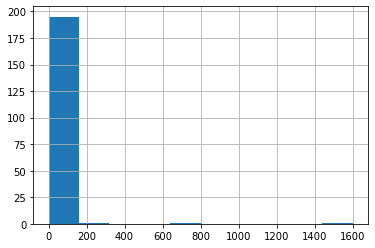

In [23]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count